# 读数据

In [1]:

import pandas as pd
import ast
# r=0.25 results_avg_20250501133031
# r=0.5 results_avg_20250509101310
# r=0.75 results_avg_20250509171620
# r=0.85 results_avg_20250509205307
# r=0.9 results_avg_20250503014640
# r=0.95 results_avg_20250510042616
# r=1   results_avg_20250510154947
file_path='/mnt/ray_tuning/ray_results/results_avg_20250510154947.csv'
df = pd.read_csv(file_path)
df = df[['config/a','config/c','avg_cvg','avg_mae','good_ratio','combined_metric','all_results']]
df['all_results'] = df['all_results'].apply(ast.literal_eval)
df.head(1)

,config/a,config/c,avg_cvg,avg_mae,good_ratio,combined_metric,all_results
0,0.527053,4,0.875,0.025354,0.092593,2.801512,"[{'tau': 0.3, 'E': 1, 'T': 1000, 'cvg': 0.94, ..."


# results展开

In [2]:
# 将 dict 中的键值展开为新的列
df_expanded = df.explode('all_results')

df_final = pd.concat([df_expanded.drop(['all_results'], axis=1),
                     df_expanded['all_results'].apply(pd.Series)], axis=1)

df_final = df_final.reset_index(drop=True)
df_final.head(1)

,config/a,config/c,avg_cvg,avg_mae,good_ratio,combined_metric,tau,E,T,cvg,mae
0,0.527053,4,0.875,0.025354,0.092593,2.801512,0.3,1.0,1000.0,0.94,0.011909


# 卡阈值，找最优

In [3]:
# 多试几个T的组合，及cvg/mae阈值，看一下现在结果的“最优”
import numpy as np
from itertools import combinations

T_choices = df_final['T'].unique().tolist()
T_combinations = list(combinations(T_choices,2))
len(T_combinations)

# 定义不同的cvg/mae阈值组合
thresholds = [
    {'cvg': 0.92, 'mae': 0.01},  # 默认阈值
    {'cvg': 0.90, 'mae': 0.01},
]

# 创建结果存储DataFrame
results = []

# 计算每个T组合和阈值下的good_ratio
for T1, T2 in T_combinations:
    # 筛选出特定T组合的数据
    mask_T = (df_final['T'] == T1) | (df_final['T'] == T2)
    df_T = df_final[mask_T]
    
    # 按(config/a, config/c)分组
    grouped = df_T.groupby(['config/a', 'config/c'])
    
    for (config_a, config_c), group in grouped:
        # 计算默认阈值下的good_ratio
        good_ratio = np.mean((group['cvg'] > 0.95) & (group['mae'] < 0.005))
        
        # 计算不同阈值下的good_ratio_adjusted
        good_ratios_adjusted = {}
        for i, threshold in enumerate(thresholds):
            ratio = np.mean((group['cvg'] > threshold['cvg']) & (group['mae'] < threshold['mae']))
            good_ratios_adjusted[f'good_ratio_adj_{i}'] = ratio
        
        # 添加到结果中
        result = {
            'T1': T1,
            'T2': T2,
            'config/a': config_a,
            'config/c': config_c,
            'good_ratio': good_ratio,
            **good_ratios_adjusted,
            'avg_cvg': group['cvg'].mean(),
            'avg_mae': group['mae'].mean(),
            'combined_metric': group['combined_metric'].mean(),
            'sample_count': len(group)
        }
        results.append(result)

# 创建结果DataFrame
df_analysis = pd.DataFrame(results)
df_analysis.head(1)

,T1,T2,config/a,config/c,good_ratio,good_ratio_adj_0,good_ratio_adj_1,avg_cvg,avg_mae,combined_metric,sample_count
0,1000.0,2000.0,0.502336,3,0.0,0.222222,0.222222,0.946111,0.021311,2.457556,18


# 画最优分布图

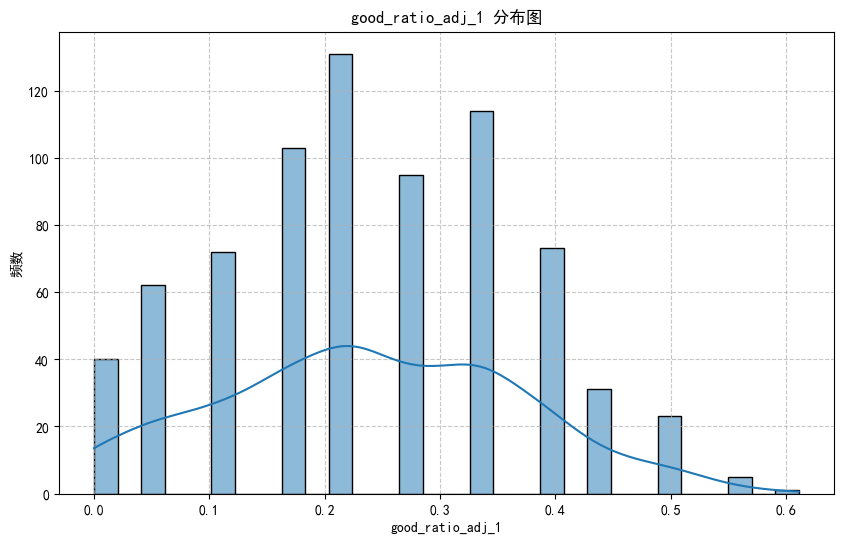

In [4]:
# 绘制 good_ratio_adj_1 的分布图
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

plt.figure(figsize=(10, 6))
sns.histplot(df_analysis['good_ratio_adj_0'], kde=True, bins=30)
plt.title('good_ratio_adj_1 分布图')
plt.xlabel('good_ratio_adj_1')
plt.ylabel('频数')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

In [66]:
# 找出 good_ratio_adj_1 第二大值所在行的数据
sorted_df = df_analysis.sort_values(by='good_ratio_adj_0', ascending=False)
# sorted_df = df_analysis.sort_values(by='combined_metric')
second_max_row = sorted_df.iloc[0]  # 获取排序后的第二行
print("good_ratio_adj_1 第二大值所在行的数据:")
print(second_max_row)


good_ratio_adj_1 第二大值所在行的数据:
T1                  10000.000000
T2                  50000.000000
config/a                0.546483
config/c                1.000000
good_ratio              0.388889
good_ratio_adj_0        0.722222
good_ratio_adj_1        0.722222
avg_cvg                 0.977222
avg_mae                 0.007202
combined_metric         2.201954
sample_count           18.000000
Name: 660, dtype: float64


In [ ]:
import pandas as pd
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows

# 定义结果文件名称映射字典
result_file_mapping = {
    'results_avg_20250501133031': 'r_zero_point_two_five_top_n_results',
    'results_avg_20250509101310': 'r_zero_point_five_top_n_results',
    'results_avg_20250509171620': 'r_zero_point_seven_five_top_n_results',
    'results_avg_20250509205307': 'r_zero_point_eight_five_top_n_results',
    'results_avg_20250503014640': 'r_zero_point_nine_top_n_results',
    'results_avg_20250510042616': 'r_zero_point_nine_five_top_n_results',
    'results_avg_20250510154947': 'r_one_top_n_results'
}

file_map_key = file_path.split('/')[-1].split('.')[0]
file_map_value = result_file_mapping[file_map_key]

# 获取sorted_df中的前五行
top_5_rows = sorted_df.head(10)

# 创建一个Excel写入器
excel_writer = pd.ExcelWriter(f'/mnt/ray_tuning/{file_map_value}.xlsx', engine='openpyxl')
print(file_map_value)
# 用于存储统计数据的列表
stats_data = []

# 为每个配置创建单独的sheet
for i, (idx, row) in enumerate(top_5_rows.iterrows(), 1):
    # 获取该配置的参数
    T1 = row['T1']
    T2 = row['T2']
    config_a = row['config/a']
    config_c = row['config/c']
    
    # 筛选出符合条件的数据
    filtered_data = df_final[
        ((df_final['T'] == T1) | (df_final['T'] == T2)) & 
        (df_final['config/a'] == config_a) & 
        (df_final['config/c'] == config_c)
    ]
    
    # 选择需要的列
    selected_columns = ['T', 'config/a', 'config/c', 'tau', 'E', 'cvg', 'mae']
    result_table = filtered_data[selected_columns].copy()
    
    # 计算统计值
    avg_cvg = result_table['cvg'].mean()
    avg_mae = result_table['mae'].mean()
    good_ratio_adjusted_0 = ((result_table['cvg'] > 0.90) & (result_table['mae'] < 0.01)).mean()
    
    # 将统计数据添加到列表
    stats_data.append({
        'Sheet': f'Config_{i}',
        'T1': T1,
        'T2': T2,
        'config/a': config_a,
        'config/c': config_c,
        'avg_cvg': avg_cvg,
        'avg_mae': avg_mae,
        'good_ratio_adjusted_0': good_ratio_adjusted_0
    })
    
    # 将数据写入Excel
    sheet_name = f'Config_{i}'
    result_table = result_table.sort_values(['T','tau','E'])
    result_table.to_excel(excel_writer, sheet_name=sheet_name, index=False)

# 创建统计数据的DataFrame
stats_df = pd.DataFrame(stats_data)

# 将统计数据写入Excel的最后一个sheet
stats_df.to_excel(excel_writer, sheet_name='Statistics', index=False)

# 保存Excel文件
excel_writer.close()

print("\nExcel文件已保存")

r_zero_point_two_five_top_n_results

Excel文件已保存
